<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/understanding_s4_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
## S4 models are used for long sequences,The goal of these kind of models are Efficient modeling for long sequences.
## Applications: Really long sequence matching like, DNA matching, Chat application for example you can talk years.
## Following the tutorial: https://srush.github.io/annotated-s4/#:~:text=The%20Structured%20State%20Space%20for,tens%20of%20thousands%20of%20steps.
## Most of the code is written in jax, we'll try to understand and re-write in python.



# What are state space models, in simple terms a model which remembers the state which is useful to it. So, mathematically they say, in simple terms
# It maps the 1D signal to N Dimensional latent space before projecting to 1D signal.
# Transforming a one-dimensional input signal into a multi-dimensional latent state before converting it back to a one-dimensional output.
# Imagine you have a simple melody (the input signal) that you play on a piano. This melody is then arranged for an orchestra (the N-dimensional latent state),
# where each instrument adds complexity and richness to the original melody. Finally, the orchestra's performance is recorded with a single microphone,
# producing a new, enriched version of the melody (the output signal). This process enriches the original input by exploring its possibilities in a higher-dimensional
# space before condensing it back into a form that's similar to the original input but more complex and nuanced

In [6]:
import numpy as np

In [10]:
"""
SSM Block where u(t) is the signal @ time t, x(t) is the N Dimensional latest space

x′(t) = Ax(t) + Bu(t)
y(t)  = Cx(t) + Du(t)

A,B,C,D are the matrix (learnable parameters)

Our goal is to simply use the SSM as a black-box representation in a deep sequence
model, where are parameters learned by gradient descent.

"""
def random_SSM(N):
    A = np.random.uniform(low=0.0, high=1.0, size=(N, N))
    B = np.random.uniform(low=0.0, high=1.0, size=(N, 1))
    C = np.random.uniform(low=0.0, high=1.0, size=(1, N))
    return A, B, C


In [9]:
random_SSM(N=5)

(array([[0.05301059, 0.34368207, 0.76692829, 0.25081378, 0.13667601],
        [0.90848259, 0.90015137, 0.95680001, 0.72836906, 0.73062383],
        [0.31095065, 0.43983436, 0.56548702, 0.84067153, 0.62415758],
        [0.22697586, 0.54753701, 0.10032978, 0.73676666, 0.12468651],
        [0.58219704, 0.64283194, 0.60756392, 0.60586405, 0.29696921]]),
 array([[0.17013911],
        [0.152374  ],
        [0.98210037],
        [0.63522387],
        [0.07065036]]),
 array([[0.30956843, 0.71549923, 0.79330042, 0.40261376, 0.58121063]]))

# Discrete-time SSM: The Recurrent Representation

---
##### The statement refers to adapting a State-Space Model (SSM), which is originally designed for continuous inputs, to work with discrete input sequences. This adaptation requires discretizing the model, which means breaking down the continuous time into discrete intervals or steps. The step size you choose will determine the resolution of your input, essentially how finely you are sampling the continuous signal to create your discrete sequence.

**Intuitive Example**
Imagine you are filming a sunset to create a time-lapse video. The continuous event is the sunset, which occurs smoothly and continuously over time. However, your camera can't capture every single moment of the sunset; instead, it takes a picture at regular intervals—say, one photo every minute. Here, the "step size" is one minute. The series of photos you get represents the discretized version of the sunset. Each photo is a discrete sample that approximates the continuous process of the sunset at that moment.

**Another Example**: **Temperature Monitoring**
Consider you're tracking the temperature in your garden over a day to understand how it changes. The temperature outside changes continuously, smoothly transitioning from the cool of the early morning to the warmth of midday and back again as the sun sets.

**Continuous Function**: If you could measure and record the temperature every infinitesimal moment, you'd have a continuous function of temperature over time. This would give you a smooth curve showing exactly how temperature changes at every moment of the day.
Discretized by a Step Size: Since continuous monitoring like this is impractical, you decide to record the temperature once every hour. This hourly recording is your "step size," turning your continuous temperature data into a discrete sequence. Each measurement is a snapshot or a sample that approximates the underlying continuous temperature changes throughout the day.
In both examples, the discrete samples (whether photos of the sunset or hourly temperature readings) provide an approximation of the continuous process. The finer the step size (more frequent photos or temperature readings), the closer your discrete sequence will resemble the continuous reality, at the cost of requiring more samples. This principle is fundamental when adapting continuous models or signals to digital or computer-based systems, which inherently operate in discrete time steps.

In [11]:
# So, To use discretization what we do here,
# To be applied on a discrete input sequence instead of continuous function u(t),
# the SSM must be discretized by a step size that represents the resolution of the
# input. Conceptually, the inputs can be viewed as sampling an implicit underlying
# continuous signal , where.

# To discretize the continuous-time SSM, we use the bilinear, which converts the
#  state matrix into an approximation. The discrete SSM is:

from numpy.linalg import inv

def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    # Computing the matrix (I - (step / 2.0) * A)^-1
    BL = inv(I - (step / 2.0) * A)
    # Discretized A matrix
    Ab = BL @ (I + (step / 2.0) * A)
    # Discretized B matrix, corrected the multiplication (*) to @ for matrix multiplication
    Bb = BL @ (B * step)
    # C remains unchanged
    return Ab, Bb, C



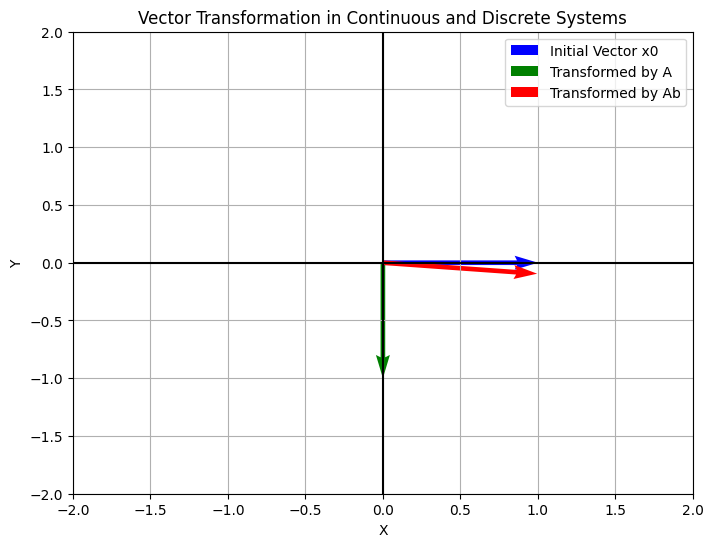

In [36]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Define the discretize function
def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = BL @ (B * step)
    return Ab, Bb, C

# Define continuous A, B, C matrices for a simple system
A = np.array([[0, 1], [-1, -1]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])

# Discretize with a step size of 0.1
step_size = 0.1
Ab, Bb, Cb = discretize(A, B, C, step_size)

# Define the initial state vector x0
x0 = np.array([1, 0])

# Compute the transformation of x0 by continuous A and discrete Ab
x_transformed_A = A @ x0
x_transformed_Ab = Ab @ x0

# Visualization of vector transformations
plt.figure(figsize=(8, 6))

# Plot the initial vector
plt.quiver(0, 0, x0[0], x0[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Initial Vector x0')

# Plot the transformed vector by A
plt.quiver(0, 0, x_transformed_A[0], x_transformed_A[1], angles='xy', scale_units='xy', scale=1, color='green', label='Transformed by A')

# Plot the transformed vector by Ab
plt.quiver(0, 0, x_transformed_Ab[0], x_transformed_Ab[1], angles='xy', scale_units='xy', scale=1, color='red', label='Transformed by Ab')

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.title('Vector Transformation in Continuous and Discrete Systems')
plt.show()
